In [43]:
# classic packages
import pandas as pd
import numpy as np
from joblib import dump, load

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# make custom libraries importable
import sys
sys.path.append('../../library')

# replacing missing values
from missing_values_utils import impute_quant_by_cat
from missing_values_utils import fit_impute_rules, apply_impute_rules

# aggregation of loca intersection data
from aggr_utils import aggr_loca_split

# cleaning dataset functions, scaling, encoding
from cleaning_utils import remove_irrelevant_cols
from cleaning_utils import distinguish_cols, print_col_categories
from cleaning_utils import QuantScaler
from cleaning_utils import rearrange_cat_cols
from cleaning_utils import encode_trigonomeric #,encode_one_hot,  encode_target

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder

# train_test_split
from sklearn.model_selection import train_test_split

# evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# model classifier
from sklearn.ensemble import RandomForestClassifier


In [54]:
df = load(r'..\..\..\temp_data\1.2-leibold-data-preprocessing_concat.joblib')
#df = df.loc[df['acc_year']==2024]
#df = df.sample(n=10000)

print(df.shape)
display(df.head(3))

(762666, 44)


,acc_num,ind_place,ind_cat,ind_severity,ind_sex,ind_trip,ind_secu1,ind_secu2,ind_location,ind_action,...,veh_id,loca_road_cat,loca_traffic_circul,loca_road_lanes,loca_road_gradient,loca_road_view,loca_road_surface_cond,loca_accident,loca_max_speed,loca_is_intersection
0,201900000001,2,2,2,2,0,1,0,<NA>,<NA>,...,138 306 524,1,3,10.0,1,2.0,1.0,1,70.0,0
1,201900000001,1,1,2,2,5,1,0,<NA>,<NA>,...,138 306 524,1,3,10.0,1,2.0,1.0,1,70.0,0
2,201900000001,1,1,1,1,0,1,0,<NA>,<NA>,...,138 306 525,1,3,10.0,1,2.0,1.0,1,70.0,0


In [55]:
print("count of cols BEFORE dropping:", df.shape[1])
df = remove_irrelevant_cols(df)
print("count of cols AFTER dropping:", df.shape[1])

count of cols BEFORE dropping: 44
count of cols AFTER dropping: 33


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 762666 entries, 0 to 807331
Data columns (total 33 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   acc_num                 762666 non-null  int64  
 1   ind_place               762666 non-null  int64  
 2   ind_cat                 762666 non-null  int64  
 3   ind_severity            762666 non-null  int64  
 4   ind_sex                 762666 non-null  int64  
 5   ind_trip                762666 non-null  int64  
 6   ind_secu1               761592 non-null  Int64  
 7   ind_age_group           762666 non-null  Int64  
 8   ind_temp_id             762666 non-null  object 
 9   acc_year                762666 non-null  int64  
 10  acc_month               762666 non-null  int64  
 11  acc_hour                762666 non-null  int64  
 12  acc_municipality        762666 non-null  object 
 13  acc_ambient_lightning   762656 non-null  float64
 14  acc_atmosphere          7

In [57]:
cols_dict = distinguish_cols(df)
#print_col_categories(cols_dict)

⚠️ Missing columns (ignored): ['ind_location', 'ind_action', 'ind_secu2', 'acc_department', 'ind_location', 'ind_action', 'ind_secu2', 'loca_road_count']


In [58]:
# 4. rearrange classes of categorical variables with high cardinality to reduce it
#------------------------------------------------
df = rearrange_cat_cols(df)

In [59]:
# -------------------------------------------------------------------------------------------------
# data split
# -------------------------------------------------------------------------------------------------
# Separate features and target
X = df.drop(columns=['ind_severity'])   # predictors
y = df['ind_severity']                  # target

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# check shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (610132, 32)
y_train shape: (610132,)
X_test shape: (152534, 32)
y_test shape: (152534,)


In [60]:
# -------------------------------------------------------------------------------------------------
# check missing values
# -------------------------------------------------------------------------------------------------
missing_vars = X_train.isna().sum()
missing_vars = missing_vars[missing_vars > 0]
print(missing_vars)

ind_secu1                   857
acc_ambient_lightning         8
acc_atmosphere               30
acc_intersection             24
acc_collision_type         2961
veh_impact                  252
veh_maneuver              34327
loca_road_lanes           17817
loca_road_view              380
loca_road_surface_cond      495
loca_max_speed            18832
dtype: int64


In [62]:
# -------------------------------------------------------------------------------------------------
# data prep 
# -------------------------------------------------------------------------------------------------
# 1. replace missing values
#------------------------------------------------
# quantitative variables: replace by distributiion of loca_road_cat, the rest randomly keeping the overall proportion
X_train = impute_quant_by_cat(X_train, quant_var="loca_road_lanes", cat_var="loca_road_cat")
X_train = impute_quant_by_cat(X_train, quant_var="loca_max_speed", cat_var="loca_road_cat")

X_test = impute_quant_by_cat(X_test, quant_var="loca_road_lanes", cat_var="loca_road_cat")
X_test = impute_quant_by_cat(X_test, quant_var="loca_max_speed", cat_var="loca_road_cat")

# categorical variables: replace randomly but keep proportion of target
categorical_cols = cols_dict["categorical"] # Get all categorical variables from cols_dict

missing_cat_cols = [col for col in categorical_cols if X_train[col].isna().any()] # Restrict to those with missing values

rules = fit_impute_rules(X_train, y_train, missing_cat_cols) # Fit rules on training set

X_train = apply_impute_rules(X_train, y_train, rules) # Apply to training set (uses y_train conditionally)

X_test = apply_impute_rules(X_test, None, rules) # Apply to test set (uses only global distributions, no y_test)


# 2. aggregate loca data
#------------------------------------------------
# Train
X_train, y_train, enc = aggr_loca_split(X_train, y_train, encoder=None)

# Test (reuse encoder; do NOT fit again)
X_test,  y_test,  _   = aggr_loca_split(X_test,  y_test, encoder=enc)

# key columns only neccessary for aggregation
X_train.drop(['ind_temp_id','acc_num'], axis=1, inplace=True)
X_test.drop(['ind_temp_id','acc_num'], axis=1, inplace=True)


# 3. scaling
#------------------------------------------------
cols_to_scale = ["loca_road_lanes", "loca_max_speed"]

scaler = MinMaxScaler()

X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])


# 4. encoding
#------------------------------------------------
# OneHot Encoder
cat_cols = cols_dict['oneHot_encoder']
valid_cat_cols = [c for c in cat_cols if c in X_train.columns]

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype='int')

X_train_encoded = encoder.fit_transform(X_train[valid_cat_cols])
X_test_encoded = encoder.transform(X_test[valid_cat_cols])

X_train_cat_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(valid_cat_cols), index=X_train.index)
X_test_cat_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(valid_cat_cols), index=X_test.index)

X_train = pd.concat([X_train.drop(columns=valid_cat_cols), X_train_cat_df], axis=1)
X_test = pd.concat([X_test.drop(columns=valid_cat_cols), X_test_cat_df], axis=1)


# Trigonomeric Encoder: acc_month, acc_hour
X_train = encode_trigonomeric(X_train)
X_test = encode_trigonomeric(X_test)

# Target Encoder: acc_municipality
encoder = TargetEncoder(cols=cols_dict['target_encoder'], smoothing=0.3) # Define target encoder

X_train = encoder.fit_transform(X_train, y_train) # Fit only on training data
X_test = encoder.transform(X_test) # Transform test data with same mapping

# # change dtype float to int (some models like randomForest struggle with that)
# float_cols = X_train.select_dtypes(include=['float64']).columns
# X_train[float_cols] = X_train[float_cols].astype('int64')

# float_cols = X_test.select_dtypes(include=['float64']).columns
# X_test[float_cols] = X_test[float_cols].astype('int64')


✅ No missing values in 'loca_road_lanes'.
🔍 Found 13657 missing values in 'loca_max_speed'. Imputing...
✅ Finished imputing 'loca_max_speed'.
🔍 Found 4503 missing values in 'loca_road_lanes'. Imputing...
✅ Finished imputing 'loca_road_lanes'.
🔍 Found 4776 missing values in 'loca_max_speed'. Imputing...
✅ Finished imputing 'loca_max_speed'.
Original shape: (564874, 149)
Encoded shape: (564874, 151)
Original shape: (149688, 149)
Encoded shape: (149688, 151)


In [63]:
X_train.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 564874 entries, 0 to 564873
Data columns (total 151 columns):
 #    Column                     Dtype  
---   ------                     -----  
 0    ind_age_group              Int64  
 1    acc_year                   int64  
 2    acc_municipality           float64
 3    loca_road_cat              int64  
 4    loca_road_lanes            float64
 5    loca_road_surface_cond     float64
 6    loca_max_speed             float64
 7    loca_is_intersection       int64  
 8    loca_traffic_circul_0      float64
 9    loca_traffic_circul_1      float64
 10   loca_traffic_circul_2      float64
 11   loca_traffic_circul_3      float64
 12   loca_traffic_circul_4      float64
 13   loca_road_gradient_0       float64
 14   loca_road_gradient_1       float64
 15   loca_road_gradient_2       float64
 16   loca_road_gradient_3       float64
 17   loca_road_gradient_4       float64
 18   loca_road_view_1.0         float64
 19   loca_road_view_2.0   

In [64]:
# --------------------------------------------------------------------------------------------------
# Random Forest Standard + class_weight="balanced"
# --------------------------------------------------------------------------------------------------
# Initialize RandomForest model
rf_model = RandomForestClassifier(
    n_estimators=200,        # number of trees
    max_depth=None,          # let trees expand fully
    min_samples_split=2,     # default split criteria
    min_samples_leaf=1,      # default leaf size
    random_state=42,         # reproducibility
    n_jobs=-1,                # use all cores for speed
    class_weight="balanced"
)

# Fit the model
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred = rf_model.predict(X_test)



✅ RandomForest Results
Accuracy: 0.713924963924964

Classification Report:
               precision    recall  f1-score   support

           1       0.76      0.84      0.80     62183
           2       0.71      0.70      0.70     60894
           3       0.57      0.49      0.53     22786
           4       0.59      0.12      0.20      3825

    accuracy                           0.71    149688
   macro avg       0.66      0.54      0.56    149688
weighted avg       0.71      0.71      0.70    149688



col_0,1,2,3,4
target,,,,
1,52513,8149,1496,25
2,13261,42747,4793,93
3,2697,8737,11158,194
4,398,967,2012,448


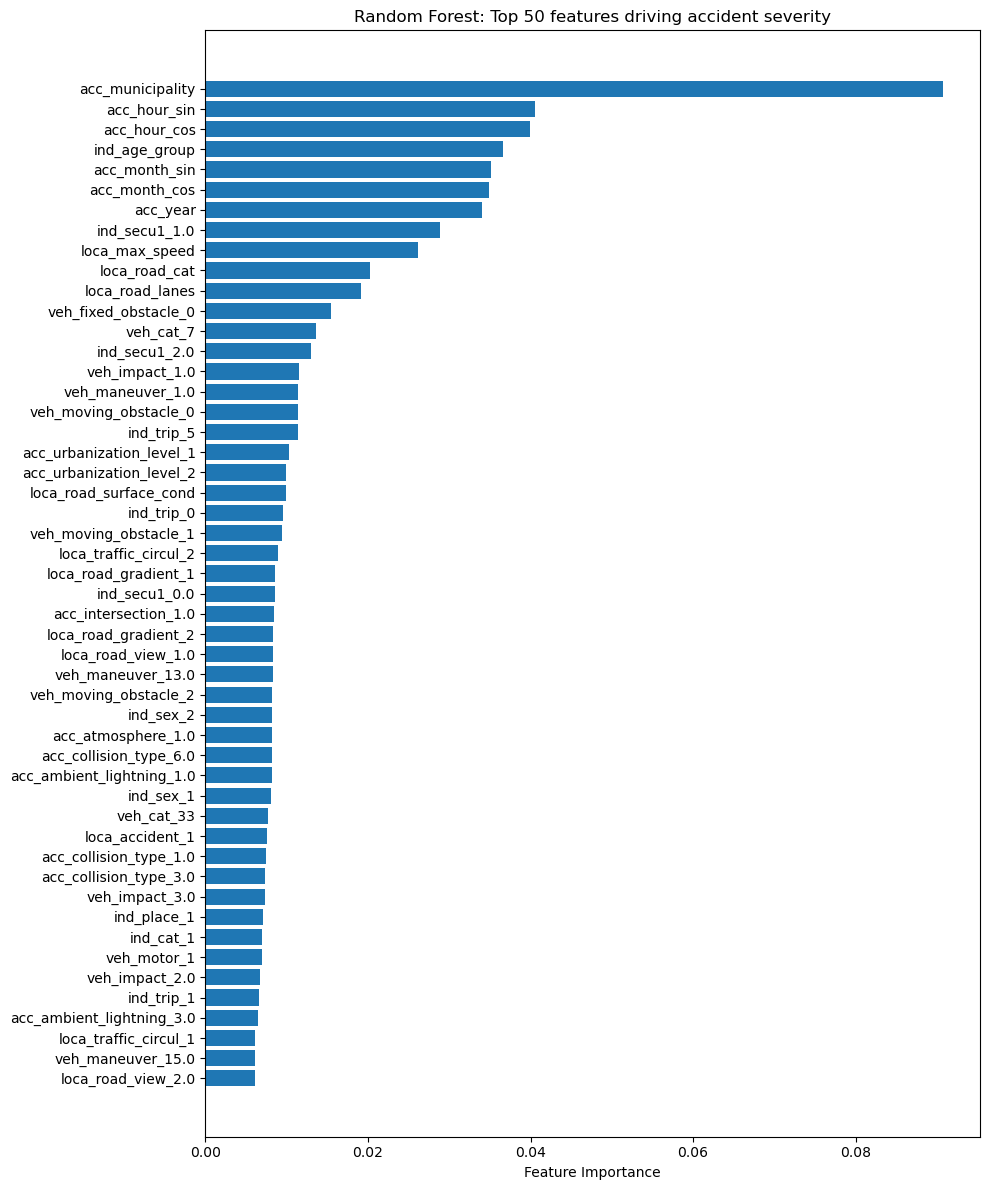

In [65]:
# --------------------------------------------------------------------------------------------------
# Evaluate performance
# --------------------------------------------------------------------------------------------------
print("✅ RandomForest Results")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
display(pd.crosstab(y_test, y_pred))
#print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# --------------------------------------------------------------------------------------------------
# Feature importance
# --------------------------------------------------------------------------------------------------
# Get feature importances from the trained RandomForest
importances = rf_model.feature_importances_
feature_names = X_train.columns

# Sort by importance
indices = np.argsort(importances)[::-1][:50]  # top 50

plt.figure(figsize=(10, 12))
plt.barh(range(len(indices)), importances[indices][::-1], align="center")
plt.yticks(range(len(indices)), feature_names[indices][::-1])
plt.xlabel("Feature Importance")
plt.title("Random Forest: Top 50 features driving accident severity")
plt.tight_layout()
plt.show()

In [66]:
# --------------------------------------------------------------------------------------------------
# Random Forest Standard + SMOTE
# --------------------------------------------------------------------------------------------------
from imblearn.over_sampling import SMOTE
import time

start = time.time()

smote = SMOTE(random_state=42)

X_train = X_train.astype(float)
y_train = y_train.astype(int)  # labels must be integers

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_smote.value_counts())

# Initialize RandomForest model
rf_smote = RandomForestClassifier(
    n_estimators=200,        # number of trees
    max_depth=None,          # let trees expand fully
    min_samples_split=2,     # default split criteria
    min_samples_leaf=1,      # default leaf size
    random_state=42,         # reproducibility
    n_jobs=-1,                # use all cores for speed
    #class_weight="balanced"
)

# Fit the model
rf_smote.fit(X_train_smote, y_train_smote)

# Predict on test set
y_pred_smote = rf_smote.predict(X_test)

end = time.time()
print("Total runtime (minutes):", (end - start) / 60)



Before SMOTE: target
1    233622
2    229468
3     86943
4     14841
Name: count, dtype: int64
After SMOTE: target
2    233622
1    233622
4    233622
3    233622
Name: count, dtype: int64
Total runtime (minutes): 8.461941941579182


✅ RandomForest Results
Accuracy: 0.71449949227727

Classification Report:
               precision    recall  f1-score   support

           1       0.77      0.84      0.80     62183
           2       0.72      0.68      0.70     60894
           3       0.55      0.54      0.55     22786
           4       0.49      0.19      0.27      3825

    accuracy                           0.71    149688
   macro avg       0.63      0.56      0.58    149688
weighted avg       0.71      0.71      0.71    149688



col_0,1,2,3,4
target,,,,
1,52372,7883,1869,59
2,13040,41460,6176,218
3,2521,7400,12397,468
4,358,753,1991,723


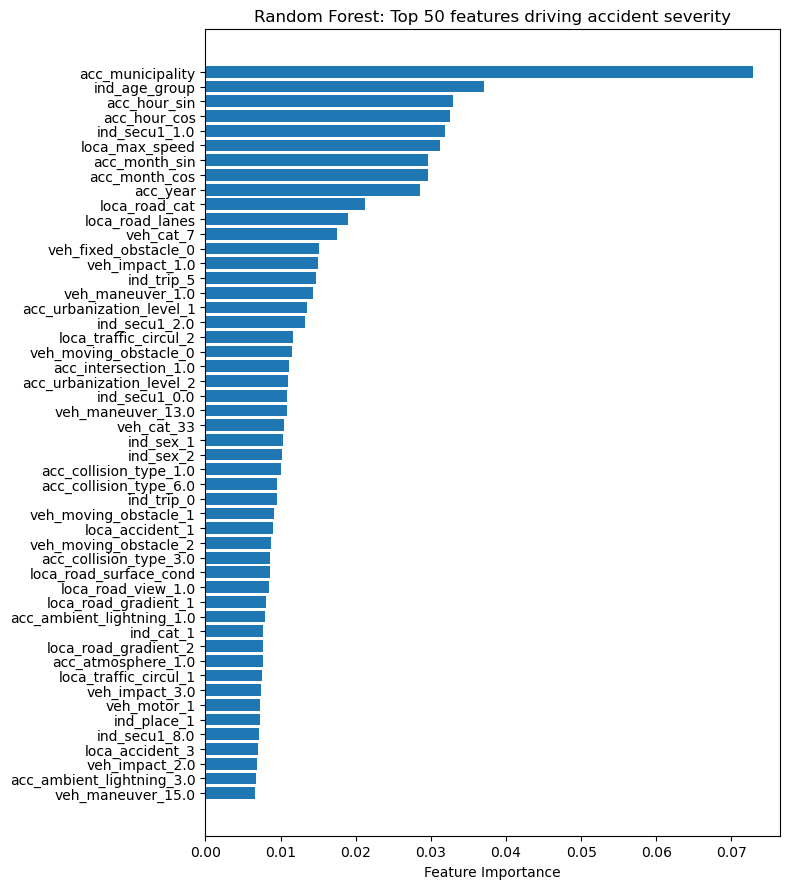

In [70]:
# --------------------------------------------------------------------------------------------------
# Evaluate performance
# --------------------------------------------------------------------------------------------------
print("✅ RandomForest Results")
print("Accuracy:", accuracy_score(y_test, y_pred_smote))
print("\nClassification Report:\n", classification_report(y_test, y_pred_smote))
display(pd.crosstab(y_test, y_pred_smote))
#print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# --------------------------------------------------------------------------------------------------
# Feature importance
# --------------------------------------------------------------------------------------------------
# Get feature importances from the trained RandomForest
importances = rf_smote.feature_importances_
feature_names = X_train_smote.columns

# Sort by importance
indices = np.argsort(importances)[::-1][:50]  # top 50

plt.figure(figsize=(8, 9))
plt.barh(range(len(indices)), importances[indices][::-1], align="center")
plt.yticks(range(len(indices)), feature_names[indices][::-1])
plt.xlabel("Feature Importance")
plt.title("Random Forest: Top 50 features driving accident severity")
plt.tight_layout()
plt.show()